<table style="background-color:#FFFFFF">   
  <tr>     
  <td><img src="https://upload.wikimedia.org/wikipedia/commons/9/95/Logo_EPFL_2019.svg" width="150x"/>
  </td>     
  <td>
  <h1> <b>CS-461: Foundation Models and Generative AI</b> </h1>
  Prof. Charlotte Bunne  
  </td>   
  </tr>
</table>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, pathlib

target = "/content/drive/MyDrive/Assignment_1/cs461_assignment1"


os.chdir(target)

print("CWD:", os.getcwd())
print("Files here:", os.listdir()[:20])

CWD: /content/drive/MyDrive/Assignment_1/cs461_assignment1
Files here: ['CS461_Assignment1.ipynb', 'report.md', 'utils.py', 'eval.py', '__pycache__', 'cs461_assignment1_data', 'checkpoints', 'logs', 'models.py']


# 📚 Graded Assignment 1  
### CS-461: Foundation Models and Generative AI - Fall 2025  - Due: October 8, 23:59 CET

Welcome to the first graded assignment!
In this assignment, you will **implement and explore self-supervised learning** on a downsampled subset of the [ImageNet-1k dataset](https://www.image-net.org/), and evaluate how well your model generalizes **both in-distribution and out-of-distribution (OOD)**.  

---

## 🎯 Learning Objectives
By completing this assignment, you will learn to:
- Implement a custom **encoder** and **projection head** for images  
- Experiment with **data augmentations** for self-supervised learning  
- Train a model using a **self-supervised loss**  
- Evaluate learned representations with **k-NN** and **linear probes**  
- Assess **out-of-distribution (OOD) generalization** to unseen classes  
- Save, visualize, and submit results in a reproducible way  

---

## ⚡ Practical Notes
- **Dataset:**  
  - Training: 200 ImageNet classes, 500 images each (100k total)  
  - Validation: 200 ImageNet classes, 50 images each (10k total)  
  - **OOD dataset:** 200 unseen classes, 50 images each (10k total)  
- Use OOD only for **evaluation**, never for training.  
- Checkpoints and evaluation intervals are already set up — your main tasks are to fill in missing functions and customize the model.  
- Some helper utilities (e.g., dataset loaders, probes) are provided in `utils.py`.  

---

👉 **Deliverables:** You will submit:
- Your modified **`models.py`**  
- Trained weights in **`final_model.safetensors`**  
- A short **report.md** (max 500 words) — including **discussion of OOD results**  
- This completed notebook **CS461_Assignment1.ipynb**  

---

⚠️ **Important:** Don’t forget to fill in your **SCIPER number** and **full name** in Section 0, otherwise you will receive **0 points**.  

First, we import packages and set up the device. \
Feel free to add any additional packages you may need.

In [3]:
%%capture
%pip install -q "ipython>=8.27.0"

In [4]:
%%capture
!pip install -q --upgrade safetensors scikit-learn scikit-learn-intelex

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
    print("✅ sklearnex acceleration enabled.")
except Exception as e:
    print("ℹ️ sklearnex not available or failed to load (that’s fine).", e)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from pathlib import Path
import shutil
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from safetensors.torch import save_model

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


# 🆔 0. SCIPER Number and Name  

⚠️ **IMPORTANT!** ⚠️  
You **must** fill in your **SCIPER number** and **full name** below.  

This is **required for automatic grading**.  
If you do **not** provide this information, you will receive **0️⃣ (zero)** for this assignment.

In [7]:
SCIPER = "329911"  # Replace with your SCIPER number
LAST_NAME = "BENCHEKROUN"  # Replace with your last name
FIRST_NAME = "ALI"  # Replace with your first name

## 1. Datasets & Utilities

- In the following, we will work with a subset of the ImageNet-1k dataset: color images downsampled to 64×64, covering 200 classes.
- The training set contains 500 images per class (100,000 images in total), and the validation set contains 50 images per class (10,000 images in total).
- The Out-Of-Distribution (OOD) datasets contain images from classes not present in the training set. It contains 50 images from 200 different classes (1,000 images in total).
- The purpose of these OOD datasets is to evaluate the generalization capabilities of the learned representations. You should not use it for training.
- During evalution, we will measure your model's performance on another OOD dataset (different from the one provided here), so make sure to not overfit on the provided OOD dataset.

<!-- Let's download/load it and define a default transformation turning a PIL Image into a `torch.tensor` -->
Make sure that you have access to the `/shared/CS461/cs461_assignment1_data/` folder. The folder structure should look like this:
```
cs461_assignment1_data/
└── train.npz
└── val.npz
└── ood.npz
```


Import dataset class and other utilities you developed in previous homeworks:

In [8]:
from utils import ImageDatasetNPZ, default_transform, seed_all
from utils import run_knn_probe, run_linear_probe, extract_features_and_labels

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


For reproducibility, you can use the provided `seed_all` function to set the random seed for all relevant libraries (Python, NumPy, PyTorch).

In [9]:
seed_all(42)

You probably want to implement custom data augmentations for the self-supervised learning method you choose. \
Feel free to swap the `default_transform` defined below and create multiple instances of datasets with different transforms.

In [10]:
data_dir = Path('./cs461_assignment1_data/')

In [11]:
import os

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

print("Data dir:", data_dir.resolve())
print("Contains:", os.listdir(data_dir) if data_dir.exists() else "❌ Missing folder")

required = ["train.npz", "val.npz", "ood.npz"]
for f in required:
    p = data_dir / f
    assert p.exists(), f"Missing {f} in {data_dir}"
print("✅ All required NPZ files present.")

Torch: 2.8.0+cu126
CUDA available: True
Device: NVIDIA L4
Data dir: /content/drive/MyDrive/Assignment_1/cs461_assignment1/cs461_assignment1_data
Contains: ['ood.npz', 'val.npz', 'train.npz']
✅ All required NPZ files present.


In [12]:
train_dataset = ImageDatasetNPZ(data_dir / 'train.npz', transform=default_transform)
val_dataset   = ImageDatasetNPZ(data_dir / 'val.npz',   transform=default_transform)

You can split the provided OOD dataset into a training and validation set using the code below. \
You should not use the training split for actually training your models, but only for evaluation (e.g. kNN or linear probing).

In [13]:
rng = np.random.RandomState(42)
ds_ood = ImageDatasetNPZ(data_dir / 'ood.npz', transform=default_transform)
ood_val_ratio = 0.2
train_mask = rng.permutation(len(ds_ood)) >= int(len(ds_ood) * ood_val_ratio)
ds_oods_train = torch.utils.data.Subset(ds_ood, np.where(train_mask)[0])
ds_oods_val   = torch.utils.data.Subset(ds_ood, np.where(~train_mask)[0])

In [14]:
batch_size = 128
num_workers = 4
pin_memory = True
collate_fn = None  # Replace with your custom collate function if needed

In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=False,
    collate_fn=collate_fn
)

Train batch images: torch.Size([128, 3, 64, 64]) torch.float32
Train batch labels: torch.Size([128]) torch.int64


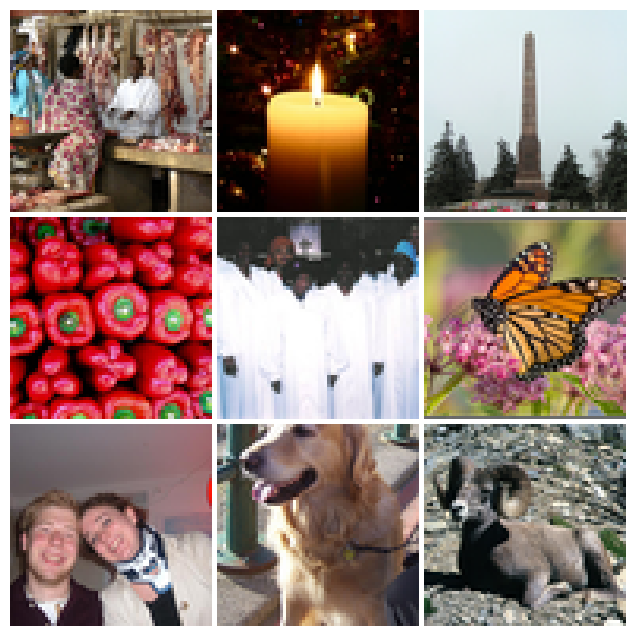

In [16]:
# here we peek one batch to verify shapes and dtypes
xb, yb = next(iter(train_loader))
print("Train batch images:", xb.shape, xb.dtype)   # we expect [B, 3, 64, 64] of type float32
print("Train batch labels:", yb.shape, yb.dtype)   # we expect [B] of type int64

# for vizualisation purposes
def show_grid(images, n=9):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid
    images = images[:n].cpu().numpy().transpose(0, 2, 3, 1)
    s = int(n ** 0.5)
    s = s if s * s == n else s + 1
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(s, s), axes_pad=0.05)
    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis('off')
    plt.show()

show_grid(xb, n=9)

# 2. Load Your Model

- Load your model from `models.py`.
- You will need to modify the `encoder` and `projection` modules, as the provided template implementation is only a placeholder.
- You SHOULD NOT change the `input_dim`, `input_channels`, and `feature_dim` parameters of the `ImageEncoder` class.
- You can use an existing architecture (e.g., ResNet, ViT) but you SHOULD NOT use any pre-trained weights.

In [17]:
from models import ImageEncoder

model = ImageEncoder().to(device)
model

ImageEncoder(
  (encoder): ConvEncoder(
    (stem): ConvBNReLU(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64,

## 3. Helpers for Training & Evaluation

We suggest you to implement the following helper functions to keep your training and evaluation loops clean and organized. \
- `training_step`: Performs a single training step (forward pass, loss computation, backward pass, optimizer step) and returns the loss value.
- `evaluation_step`: Evaluates the model on the validation dataset and returns the accuracy.

Depending on your specific requirements, you may also want to implement additional utility functions for tasks such as data loading, metric computation, and logging.

As you have seen from previous assignments, loss functions for self-supervised learning objectives can be quite complex. \
Feel free to implement any helper functions you may need to compute the loss.


In [18]:
from contextlib import nullcontext

def training_step(model,
                  batch,
                  optimizer,
                  loss_fn,
                  device,
                  scaler=None,
                  make_two_views=None,
                  temperature=0.5,
                  clip_grad=None):
    """
    One training step for SimCLR-style methods.
    """
    model.train()

    # here we unpack batch and/or create two views
    if isinstance(batch[0], (list, tuple)) and len(batch[0]) == 2:
        (x1, x2), y = batch
    else:
        x, y = batch
        if make_two_views is None:
            raise ValueError("Batch has one view but make_two_views is None. "
                             "Provide a function that returns (x1, x2) from x.")
        x1, x2 = make_two_views(x)

    x1 = x1.to(device, non_blocking=True)
    x2 = x2.to(device, non_blocking=True)

    optimizer.zero_grad(set_to_none=True)

    # forward + loss with proper autocast
    use_amp = (scaler is not None) and device.startswith('cuda')
    ctx = torch.amp.autocast(device_type='cuda', enabled=True) if use_amp else nullcontext()

    with ctx:
        _, z1 = model(x1)  # (B, proj_dim)
        _, z2 = model(x2)  # (B, proj_dim)
        loss = loss_fn(z1, z2, temperature=temperature)

    # backward + step (AMP or FP32)
    if use_amp:
        scaler.scale(loss).backward()
        if clip_grad is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
        scaler.step(optimizer)
        scaler.update()
    else:
        loss.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
        optimizer.step()

    return float(loss.detach().item())

In [19]:
def evaluation_step(model,
                    train_loader,
                    val_loader,
                    device,
                    normalize=True,
                    knn_k=5):
    """
    Evaluate frozen features via k-NN and linear probes.

    Args:
      model: your ImageEncoder (must implement get_features(x)->(B,1000))
      train_loader: DataLoader over training split (single-view is fine)
      val_loader: DataLoader over validation split
      device: 'cuda' or 'cpu'
      normalize: if True, L2-normalize features row-wise before probing
      knn_k: number of neighbors for k-NN probe

    Returns:
      dict with:
        - 'knn_acc': float in [0,1]
        - 'linear_acc': float in [0,1]
    """
    # no_grad + device moves internally and return CPU tensors
    train_features, train_labels = extract_features_and_labels(model, train_loader, normalize=normalize)
    val_features,   val_labels   = extract_features_and_labels(model, val_loader,   normalize=normalize)

    train_X = train_features.numpy() # to be safe
    train_y = train_labels.numpy()
    val_X   = val_features.numpy()
    val_y   = val_labels.numpy()

    knn_acc    = run_knn_probe(train_X, train_y, val_X, val_y)
    linear_acc = run_linear_probe(train_X, train_y, val_X, val_y)

    return {'knn_acc': float(knn_acc), 'linear_acc': float(linear_acc)}


In [20]:
def custom_loss_function(z1, z2, temperature=0.5):
    """
    SimCLR NT-Xent loss on two batches of projected embeddings.

    Args:
      z1, z2: (B, D) projected features from two stochastic views of the same images
      temperature: scalar temperature tau

    Returns:
      scalar loss (torch.Tensor)
    """
    # L2-normalize : dot product = cosine similarity
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    B = z1.shape[0]
    z = torch.cat([z1, z2], dim=0) # (2B, D)
    # cosine similarity matrix (2B x 2B)
    sim = torch.matmul(z, z.T) # cosine since normalized

    # we remove similarity with itself from the denominator by masking diagonal and we scale by temperature
    sim = sim / temperature

    # for each of the 2B anchors, define its positive index:
    # --> first B anchors (z1): positives are the next B (paired z2)
    # --> last  B anchors (z2): positives are the first B (paired z1)
    labels = torch.arange(2 * B, device=z.device)
    labels = (labels + B) % (2 * B)                     # i --> i+B (modulo 2B)

    # we mask out self-similarity to avoid trivial solutions
    # just to note we have that for i in first half, its positive is i+B; for second half, positive is i-B
    mask = torch.eye(2 * B, device=z.device, dtype=torch.bool)
    sim = sim.masked_fill(mask, float('-inf'))

    # cross-entropy over the 2B-1 negatives + 1 positive (all indexed by labels)
    loss = F.cross_entropy(sim, labels)

    return loss

# 4. Optimizer Configuration

In [21]:
# Feel free to adapt and add more arguments

# Optimization
lr = 1e-3
weight_decay = 5e-2
lr_step_size = 10
lr_gamma = 0.1


In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

In [23]:
# --- Recommended config for SimCLR-style training on Colab ---

# we scale LR with batch size (256 here), we compute 'scaled_lr' and use it below
scaled_lr = lr * (batch_size / 256)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=scaled_lr,
    weight_decay=weight_decay,
    betas=(0.9, 0.95)
)

from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

epochs = 100
warmup_epochs = 10

# linear warmup from very small to full LR
warmup = LinearLR(
    optimizer,
    start_factor=1e-3,   # start at 0.1% of LR to avoid early instabilities
    end_factor=1.0,
    total_iters=warmup_epochs
)

# cosine decay for the remaining epochs
cosine = CosineAnnealingLR(
    optimizer,
    T_max=max(1, epochs - warmup_epochs)
)

# we do the first warmup and then cosine
lr_scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup, cosine],
    milestones=[warmup_epochs]
)

# AMP scaler
scaler = torch.cuda.amp.GradScaler(enabled=device.startswith('cuda'))

# gradient clipping if set in training later
max_grad_norm = 1.0

print(f"Using AdamW with scaled_lr={scaled_lr:.3e}, weight_decay={weight_decay}")
print(f"Schedule: {warmup_epochs} warmup epochs -> cosine for {max(1, epochs-warmup_epochs)} epochs")

Using AdamW with scaled_lr=5.000e-04, weight_decay=0.05
Schedule: 10 warmup epochs -> cosine for 90 epochs


/tmp/ipython-input-119391534.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.startswith('cuda'))


# 5. Training Loop

Adapt your training configuration and implement the training loop. \
You probably want to save model checkpoints and evaluate the model on the validation set at regular intervals.

In [24]:
n_epochs = 50  # Adjust the number of epochs as needed
eval_interval = 5  # Evaluate the model every 'eval_interval' epochs
save_interval = 10  # Save the model every 'save_interval' epochs

checkpoints_dir = Path('checkpoints')
if not checkpoints_dir.exists():
    checkpoints_dir.mkdir(parents=True, exist_ok=False)


In [25]:
# SimCLR augmentations for 64x64 images (per-view, per-sample)
simclr_view = T.Compose([
    T.ToPILImage(),
    T.RandomResizedCrop(size=64, scale=(0.2, 1.0), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=9, sigma=(0.1, 2.0)),
    T.ToTensor(),  # back to tensor in [0,1]
])

def make_two_views(x_batch: torch.Tensor):
    """
    Create two independently augmented views for a batch of images.
    x_batch: (B, 3, 64, 64) tensor on CPU or GPU
    Returns: (x1, x2) both (B, 3, 64, 64) tensors on CPU (training_step will move to device)
    """
    # we ensure CPU for PIL-based transforms; bcs fast enough for assignment scale
    xb_cpu = x_batch.detach().cpu()
    v1 = torch.stack([simclr_view(img) for img in xb_cpu], dim=0)
    v2 = torch.stack([simclr_view(img) for img in xb_cpu], dim=0)
    return v1, v2

# SimCLR temperature & optional gradient clipping come from Section 4 config
tau = 0.5


In [26]:
from safetensors.torch import load_model, save_model
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from tqdm import tqdm


In [ ]:
best_linear = -1.0
best_ckpt   = None

for epoch in tqdm(range(n_epochs), desc="Training"):
    # for one epoch
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        loss_val = training_step(
            model=model,
            batch=batch,                       # (x, y), we will make two views inside
            optimizer=optimizer,
            loss_fn=custom_loss_function,      # NT-Xent loss
            device=device,
            scaler=scaler,                     # scaler from section 4 (AMP)
            make_two_views=make_two_views,
            temperature=tau,
            clip_grad=max_grad_norm            # se back section 4
        )
        running_loss += loss_val

    avg_train_loss = running_loss / max(1, len(train_loader))

    # step LR scheduler
    lr_scheduler.step()
    curr_lr = optimizer.param_groups[0]["lr"]

    # periodic evaluation and printing
    if ((epoch + 1) % eval_interval) == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            stats = evaluation_step(
                model, train_loader, val_loader,
                device=device, normalize=True, knn_k=5
            )
        knn_acc    = stats['knn_acc']    # in [0,1]
        linear_acc = stats['linear_acc'] # in [0,1]

        print(f"Epoch {epoch+1:03d}/{n_epochs} | "
              f"Train loss: {avg_train_loss:.4f} | "
              f"kNN@5: {knn_acc:.4f} | Linear: {linear_acc:.4f} | "
              f"LR: {curr_lr:.2e}")

        # we track and save the best linear probe checkpoint
        if linear_acc > best_linear:
            best_linear = linear_acc
            best_ckpt = checkpoints_dir / "model_best_linear.safetensors"
            save_model(model, best_ckpt)
            print(f"✅ New best linear probe: {best_linear:.4f} — saved {best_ckpt}")

    # periodic checkpoint
    if ((epoch + 1) % save_interval) == 0:
        ckpt_path = checkpoints_dir / f"model_epoch_{epoch+1}.safetensors"
        save_model(model, ckpt_path)
        print(f"💾 Checkpoint saved: {ckpt_path}")

# final model weights for submission
final_eval_name = checkpoints_dir / 'final_model.safetensors'
save_model(model, final_eval_name)
print(f"📦 Eval-compatible copy saved: {final_eval_name}")


Training:   2%|▏         | 1/50 [10:19<8:25:43, 619.26s/it]

Epoch 001/50 | Train loss: 5.0565 | kNN@5: 0.0409 | Linear: 0.0608 | LR: 5.04e-05
✅ New best linear probe: 0.0608 — saved checkpoints/model_best_linear.safetensors


Training:  10%|█         | 5/50 [50:49<7:48:30, 624.69s/it]

Epoch 005/50 | Train loss: 4.1011 | kNN@5: 0.0901 | Linear: 0.1460 | LR: 2.50e-04
✅ New best linear probe: 0.1460 — saved checkpoints/model_best_linear.safetensors


Training:  18%|█▊        | 9/50 [1:29:25<6:42:07, 588.48s/it]/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 010/50 | Train loss: 4.0269 | kNN@5: 0.1244 | Linear: 0.1775 | LR: 5.00e-04
✅ New best linear probe: 0.1775 — saved checkpoints/model_best_linear.safetensors


Training:  20%|██        | 10/50 [1:40:45<6:51:14, 616.87s/it]

💾 Checkpoint saved: checkpoints/model_epoch_10.safetensors


Training:  30%|███       | 15/50 [2:30:41<5:59:21, 616.05s/it]

Epoch 015/50 | Train loss: 3.9773 | kNN@5: 0.1455 | Linear: 0.2028 | LR: 4.96e-04
✅ New best linear probe: 0.2028 — saved checkpoints/model_best_linear.safetensors


Training:  38%|███▊      | 19/50 [3:09:14<5:03:32, 587.51s/it]

Epoch 020/50 | Train loss: 3.9467 | kNN@5: 0.1570 | Linear: 0.2164 | LR: 4.85e-04
✅ New best linear probe: 0.2164 — saved checkpoints/model_best_linear.safetensors


Training:  40%|████      | 20/50 [3:19:40<4:59:26, 598.88s/it]

💾 Checkpoint saved: checkpoints/model_epoch_20.safetensors


Training:  50%|█████     | 25/50 [4:09:11<4:12:09, 605.19s/it]

Epoch 025/50 | Train loss: 3.9266 | kNN@5: 0.1752 | Linear: 0.2345 | LR: 4.67e-04
✅ New best linear probe: 0.2345 — saved checkpoints/model_best_linear.safetensors


Training:  58%|█████▊    | 29/50 [4:47:43<3:24:38, 584.67s/it]

Epoch 030/50 | Train loss: 3.9099 | kNN@5: 0.1895 | Linear: 0.2484 | LR: 4.42e-04
✅ New best linear probe: 0.2484 — saved checkpoints/model_best_linear.safetensors


Training:  60%|██████    | 30/50 [4:58:36<3:21:41, 605.08s/it]

💾 Checkpoint saved: checkpoints/model_epoch_30.safetensors


Training:  70%|███████   | 35/50 [5:48:31<2:33:20, 613.35s/it]

Epoch 035/50 | Train loss: 3.8998 | kNN@5: 0.2005 | Linear: 0.2609 | LR: 4.11e-04
✅ New best linear probe: 0.2609 — saved checkpoints/model_best_linear.safetensors


Training:  78%|███████▊  | 39/50 [6:27:05<1:47:32, 586.63s/it]

Epoch 040/50 | Train loss: 3.8901 | kNN@5: 0.2127 | Linear: 0.2697 | LR: 3.75e-04
✅ New best linear probe: 0.2697 — saved checkpoints/model_best_linear.safetensors


Training:  80%|████████  | 40/50 [6:37:50<1:40:43, 604.36s/it]

💾 Checkpoint saved: checkpoints/model_epoch_40.safetensors


Training:  90%|█████████ | 45/50 [7:27:52<51:14, 614.98s/it]

Epoch 045/50 | Train loss: 3.8821 | kNN@5: 0.2171 | Linear: 0.2803 | LR: 3.36e-04
✅ New best linear probe: 0.2803 — saved checkpoints/model_best_linear.safetensors


In [ ]:
# here we do the exact same thing but resuming from an epoch x for which we already saved checkpoint

# resume configuration
resume_from   = 110
total_epochs  = 150
eval_interval = globals().get("eval_interval", 5)
save_interval = globals().get("save_interval", 10)
checkpoints_dir = Path(globals().get("checkpoints_dir", "checkpoints"))
tau = globals().get("tau", 0.5)
max_grad_norm = globals().get("max_grad_norm", 1.0)
warmup_epochs = globals().get("warmup_epochs", 10)


checkpoints_dir.mkdir(parents=True, exist_ok=True)

# this is a helper to rebuild scheduler bcs with previous code no scheduler state saved
def build_scheduler(optimizer, total_epochs, warmup_epochs):
    warmup = LinearLR(optimizer, start_factor=1e-3, end_factor=1.0, total_iters=warmup_epochs)
    cosine = CosineAnnealingLR(optimizer, T_max=max(1, total_epochs - warmup_epochs))
    return SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])

# we try to load model + optimizer/scheduler/scaler state ----
start_epoch = int(resume_from)

if start_epoch > 0:
    # 1) Load model weights saved after 'start_epoch' completed
    weight_path = checkpoints_dir / f"model_epoch_{start_epoch}.safetensors"
    if not weight_path.exists():
        have = sorted([p.name for p in checkpoints_dir.glob("model_epoch_*.safetensors")])
        raise FileNotFoundError(f"Missing {weight_path}. Available: {have if have else 'none'}")
    load_model(model, str(weight_path))
    print(f"🔁 Loaded model weights from: {weight_path}")

    # 2) Load optimizer/scheduler/AMP + metadata if available (exact resume)
    state_path = checkpoints_dir / f"state_epoch_{start_epoch}.pt"
    if state_path.exists():
        state = torch.load(state_path, map_location='cpu')
        # Ensure 'optimizer' and 'lr_scheduler' objects exist before loading
        optimizer.load_state_dict(state["optimizer"])
        try:
            lr_scheduler.load_state_dict(state["scheduler"])
        except Exception as e:
            # If scheduler type/config differs, rebuild a compatible one and retry
            print("ℹ️ Rebuilding scheduler before loading its state:", e)
            lr_scheduler = build_scheduler(optimizer, total_epochs, warmup_epochs)
            lr_scheduler.load_state_dict(state["scheduler"])
        if scaler is not None and state.get("scaler") is not None:
            scaler.load_state_dict(state["scaler"])
        # Restore best metrics if present
        best_linear = state.get("best_linear", globals().get("best_linear", -1.0))
        print(f"🧠 Optimizer/Scheduler/Scaler states restored from: {state_path}")
    else:
        # Fallback: rebuild scheduler and advance it 'start_epoch' times (approximate resume)
        print("ℹ️ No saved optimizer/scheduler state found. Rebuilding scheduler and advancing it.")
        lr_scheduler = build_scheduler(optimizer, total_epochs, warmup_epochs)
        for _ in range(start_epoch):
            lr_scheduler.step()
        best_linear = globals().get("best_linear", -1.0)
else:
    print("🚀 Starting from scratch (resume_from=0).")
    best_linear = globals().get("best_linear", -1.0)

best_ckpt = globals().get("best_ckpt", None)

# histories that we can save for plotting later, but we finally didn't use as the initial code running on the first 50 epochs didn't save anything of this
train_losses_history = globals().get("train_losses_history", [])
eval_epochs          = globals().get("eval_epochs", [])
knn_history          = globals().get("knn_history", [])
linear_history       = globals().get("linear_history", [])

# main training loop with same cadence as before
for epoch in tqdm(range(start_epoch, total_epochs), desc="Training (resume-capable)"):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        loss_val = training_step(
            model=model,
            batch=batch,
            optimizer=optimizer,
            loss_fn=custom_loss_function,  # NT-Xent
            device=device,
            scaler=scaler,
            make_two_views=make_two_views,
            temperature=tau,
            clip_grad=max_grad_norm
        )
        running_loss += loss_val

    avg_train_loss = running_loss / max(1, len(train_loader))
    train_losses_history.append(avg_train_loss)

    lr_scheduler.step()
    curr_lr = optimizer.param_groups[0]["lr"]

    if ((epoch + 1) % eval_interval) == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            stats = evaluation_step(
                model, train_loader, val_loader,
                device=device, normalize=True, knn_k=5
            )
        knn_acc    = stats['knn_acc']    # [0,1]
        linear_acc = stats['linear_acc'] # [0,1]
        eval_epochs.append(epoch + 1)
        knn_history.append(knn_acc)
        linear_history.append(linear_acc)

        print(f"Epoch {epoch+1:03d}/{total_epochs} | "
              f"Train loss: {avg_train_loss:.4f} | "
              f"kNN@5: {knn_acc:.4f} | Linear: {linear_acc:.4f} | "
              f"LR: {curr_lr:.2e}")

        if linear_acc > best_linear:
            best_linear = linear_acc
            best_ckpt = checkpoints_dir / "model_best_linear.safetensors"
            save_model(model, best_ckpt)
            print(f"✅ New best linear probe: {best_linear:.4f} — saved {best_ckpt}")

    if ((epoch + 1) % save_interval) == 0:
        ckpt_w = checkpoints_dir / f"model_epoch_{epoch+1}.safetensors"
        save_model(model, ckpt_w)
        # Save optimizer/scheduler/scaler states for exact resume later
        ckpt_s = checkpoints_dir / f"state_epoch_{epoch+1}.pt"
        torch.save({
            "epoch": epoch + 1,
            "optimizer": optimizer.state_dict(),
            "scheduler": lr_scheduler.state_dict(),
            "scaler": scaler.state_dict() if scaler is not None else None,
            "best_linear": best_linear
        }, ckpt_s)
        print(f"💾 Saved: {ckpt_w} and {ckpt_s}")


final_eval_name  = checkpoints_dir / 'final_model.safetensors'  # name expected by eval.py for submission
save_model(model, final_eval_name)

final_state_path = checkpoints_dir / 'state_final.pt'
torch.save({
    "epoch": total_epochs,
    "optimizer": optimizer.state_dict(),
    "scheduler": lr_scheduler.state_dict(),
    "scaler": scaler.state_dict() if scaler is not None else None,
    "best_linear": best_linear
}, final_state_path)

print(f"📦 Eval-compatible copy saved: {final_eval_name}")
print(f"🧠 Final training state saved: {final_state_path}")


🔁 Loaded model weights from: checkpoints/model_epoch_110.safetensors
🧠 Optimizer/Scheduler/Scaler states restored from: checkpoints/state_epoch_110.pt


Training (resume-capable):  10%|█         | 4/40 [38:18<5:44:31, 574.21s/it]

Epoch 115/150 | Train loss: 3.8038 | kNN@5: 0.2880 | Linear: 0.3438 | LR: 7.32e-05


Training (resume-capable):  12%|█▎        | 5/40 [49:03<5:49:45, 599.58s/it]

✅ New best linear probe: 0.3438 — saved checkpoints/model_best_linear.safetensors


Training (resume-capable):  22%|██▎       | 9/40 [1:27:17<4:59:17, 579.27s/it]

Epoch 120/150 | Train loss: 3.7988 | kNN@5: 0.2947 | Linear: 0.3450 | LR: 5.45e-05
✅ New best linear probe: 0.3450 — saved checkpoints/model_best_linear.safetensors


Training (resume-capable):  25%|██▌       | 10/40 [1:37:59<4:59:21, 598.71s/it]

💾 Saved: checkpoints/model_epoch_120.safetensors and checkpoints/state_epoch_120.pt


Training (resume-capable):  38%|███▊      | 15/40 [2:27:31<4:10:07, 600.29s/it]

Epoch 125/150 | Train loss: 3.7956 | kNN@5: 0.2933 | Linear: 0.3482 | LR: 3.83e-05
✅ New best linear probe: 0.3482 — saved checkpoints/model_best_linear.safetensors


Training (resume-capable):  48%|████▊     | 19/40 [3:05:57<3:23:41, 581.99s/it]

Epoch 130/150 | Train loss: 3.7916 | kNN@5: 0.2878 | Linear: 0.3489 | LR: 2.48e-05
✅ New best linear probe: 0.3489 — saved checkpoints/model_best_linear.safetensors


Training (resume-capable):  50%|█████     | 20/40 [3:17:01<3:22:13, 606.68s/it]

💾 Saved: checkpoints/model_epoch_130.safetensors and checkpoints/state_epoch_130.pt


Training (resume-capable):  62%|██████▎   | 25/40 [4:06:26<2:31:25, 605.72s/it]

Epoch 135/150 | Train loss: 3.7867 | kNN@5: 0.2890 | Linear: 0.3484 | LR: 1.40e-05


Training (resume-capable):  72%|███████▎  | 29/40 [4:44:51<1:46:58, 583.48s/it]

Epoch 140/150 | Train loss: 3.7831 | kNN@5: 0.2905 | Linear: 0.3405 | LR: 6.27e-06


Training (resume-capable):  75%|███████▌  | 30/40 [4:55:12<1:39:06, 594.68s/it]

💾 Saved: checkpoints/model_epoch_140.safetensors and checkpoints/state_epoch_140.pt


Training (resume-capable):  88%|████████▊ | 35/40 [5:45:03<50:45, 609.07s/it]

Epoch 145/150 | Train loss: 3.7921 | kNN@5: 0.2902 | Linear: 0.3499 | LR: 1.57e-06
✅ New best linear probe: 0.3499 — saved checkpoints/model_best_linear.safetensors


Training (resume-capable):  98%|█████████▊| 39/40 [6:23:49<09:48, 588.55s/it]

Epoch 150/150 | Train loss: 3.7922 | kNN@5: 0.2895 | Linear: 0.3485 | LR: 0.00e+00


Training (resume-capable): 100%|██████████| 40/40 [6:35:18<00:00, 592.96s/it]

💾 Saved: checkpoints/model_epoch_150.safetensors and checkpoints/state_epoch_150.pt


🎯 Final model saved: checkpoints/model_final.safetensors
📦 Eval-compatible copy saved: checkpoints/final_model.safetensors
🧠 Final training state saved: checkpoints/state_final.pt


In [27]:
# we ensure we're evaluating a *trained* model in eval mode
# best_ckpt = checkpoints_dir / "model_best_linear.safetensors"
best_ckpt = checkpoints_dir / "final_model.safetensors"
load_model(model, str(best_ckpt))
model.eval()  # very important as extract_features_and_labels doesn't set eval()

ImageEncoder(
  (encoder): ConvEncoder(
    (stem): ConvBNReLU(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64,

In [39]:
# Build OOD loaders (we already created ds_oods_train / ds_oods_val earlier)
ood_train_loader = DataLoader(
    ds_oods_train, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory, collate_fn=collate_fn
)
ood_val_loader = DataLoader(
    ds_oods_val, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory, collate_fn=collate_fn
)

# Extract features (normalized) — ID
id_train_X, id_train_y = extract_features_and_labels(model, train_loader, normalize=True)
id_val_X,   id_val_y   = extract_features_and_labels(model, val_loader,   normalize=True)

# Extract features (normalized) — OOD
ood_train_X, ood_train_y = extract_features_and_labels(model, ood_train_loader, normalize=True)
ood_val_X,   ood_val_y   = extract_features_and_labels(model, ood_val_loader,   normalize=True)

# Convert to numpy for sklearn
id_train_X, id_train_y = id_train_X.numpy(), id_train_y.numpy()
id_val_X,   id_val_y   = id_val_X.numpy(),   id_val_y.numpy()
ood_train_X, ood_train_y = ood_train_X.numpy(), ood_train_y.numpy()
ood_val_X,   ood_val_y   = ood_val_X.numpy(),   ood_val_y.numpy()

# Probes — ID
id_knn    = run_knn_probe(id_train_X,  id_train_y,  id_val_X,  id_val_y)
id_linear = run_linear_probe(id_train_X, id_train_y, id_val_X, id_val_y)

# Probes — OOD
ood_knn    = run_knn_probe(ood_train_X,  ood_train_y,  ood_val_X,  ood_val_y)
ood_linear = run_linear_probe(ood_train_X, ood_train_y, ood_val_X, ood_val_y)

print("In-Distribution (ID):")
print(f"  k-NN@5:  {id_knn:.4f}  ({id_knn*100:.2f}%)")
print(f"  Linear:  {id_linear:.4f}  ({id_linear*100:.2f}%)")

print("Out-of-Distribution (OOD):")
print(f"  k-NN@5:  {ood_knn:.4f}  ({ood_knn*100:.2f}%)")
print(f"  Linear:  {ood_linear:.4f}  ({ood_linear*100:.2f}%)")

In-Distribution (ID):
  k-NN@5:  0.2895  (28.95%)
  Linear:  0.3482  (34.82%)
Out-of-Distribution (OOD):
  k-NN@5:  0.1945  (19.45%)
  Linear:  0.2355  (23.55%)


# 6. Visualize Results

To better understand the performance of your trained model, visualize some results. \
You can visualize:
- Sample images from the validation set along with their predicted labels.
- Training and validation loss curves over epochs.

⏳ Extracting features...
⏳ Fitting probes...
✅ k-NN@5 accuracy:  0.2895  (28.95%)
✅ Linear accuracy: 0.3479  (34.79%)
🖼️ Sample predictions on validation batch:


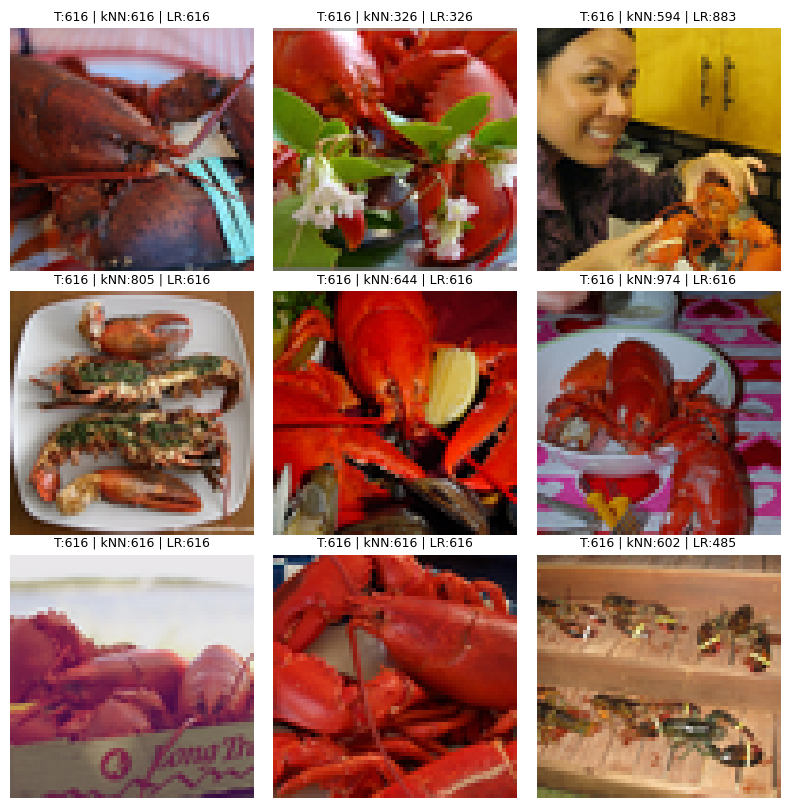

⏳ Running t-SNE projection (this may take ~1–2 minutes)...


/usr/local/lib/python3.12/dist-packages/daal4py/sklearn/manifold/_t_sne.py:365: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


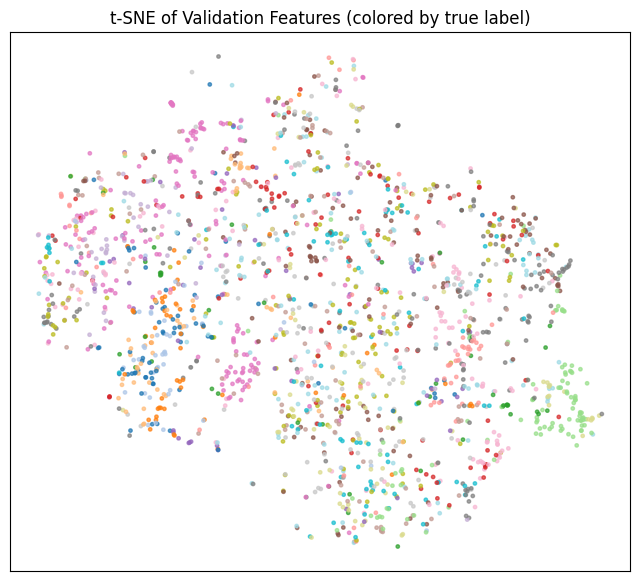

In [40]:
# TODO: Visualize some results from your trained model.

# In this first cell, we visualize a small grid of validation images with predicted labels and the t-SNE of validation features

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as skm
from sklearn.manifold import TSNE
import inspect

# 1) Extract frozen features (normalized) for train/val
print("⏳ Extracting features...")
train_feats, train_lbls = extract_features_and_labels(model, train_loader, normalize=True)
val_feats,   val_lbls   = extract_features_and_labels(model, val_loader,   normalize=True)

train_X = train_feats.numpy()
train_y = train_lbls.numpy()
val_X   = val_feats.numpy()
val_y   = val_lbls.numpy()

# 2) Fit k-NN and Logistic Regression, evaluate on val
print("⏳ Fitting probes...")
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(train_X, train_y)
val_knn_preds = knn.predict(val_X)
knn_acc = skm.accuracy_score(val_y, val_knn_preds)

logreg = LogisticRegression(max_iter=2000, n_jobs=-1)
logreg.fit(train_X, train_y)
val_lr_preds = logreg.predict(val_X)
lr_acc = skm.accuracy_score(val_y, val_lr_preds)

print(f"✅ k-NN@5 accuracy:  {knn_acc:.4f}  ({knn_acc*100:.2f}%)")
print(f"✅ Linear accuracy: {lr_acc:.4f}  ({lr_acc*100:.2f}%)")

# 3) Visualize a small grid of validation images with predicted labels
def show_pred_grid(dataloader, n=9):
    xb, yb = next(iter(dataloader))              # one batch
    with torch.no_grad():
        feats_b = model.get_features(xb.to(device)).cpu()
        feats_b = F.normalize(feats_b, dim=1)
    knn_p  = knn.predict(feats_b.numpy())
    lr_p   = logreg.predict(feats_b.numpy())

    imgs = xb[:n].cpu().numpy().transpose(0, 2, 3, 1)  # NCHW -> NHWC

    s = int(n ** 0.5)
    s = s if s * s == n else s + 1
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(s, s), axes_pad=0.2)

    for ax, im, t, pk, pl in zip(grid, imgs, yb[:n].tolist(), knn_p[:n].tolist(), lr_p[:n].tolist()):
        ax.imshow(im)
        ax.set_title(f"T:{t} | kNN:{pk} | LR:{pl}", fontsize=9)
        ax.axis('off')
    plt.show()

print("🖼️ Sample predictions on validation batch:")
show_pred_grid(val_loader, n=9)

# 4) t-SNE of validation features (subset for speed) — robust to sklearn version
print("⏳ Running t-SNE projection (this may take ~1–2 minutes)...")
rng = np.random.RandomState(42)
max_points = 2000
idx = rng.choice(len(val_X), size=min(max_points, len(val_X)), replace=False)
val_X_sub = val_X[idx]
val_y_sub = val_y[idx]

# Detect whether this sklearn uses 'max_iter' (new) or 'n_iter' (old)
tsne_sig = inspect.signature(TSNE.__init__)
tsne_kwargs = dict(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
if 'max_iter' in tsne_sig.parameters:
    tsne_kwargs['max_iter'] = 1000
else:
    tsne_kwargs['n_iter'] = 1000

# (Optional but often helpful) square distances param exists on newer versions
if 'square_distances' in tsne_sig.parameters:
    tsne_kwargs['square_distances'] = True

tsne = TSNE(**tsne_kwargs)
val_2d = tsne.fit_transform(val_X_sub)

plt.figure(figsize=(8, 7))
plt.scatter(val_2d[:, 0], val_2d[:, 1], c=val_y_sub, s=6, alpha=0.7, cmap='tab20')
plt.title("t-SNE of Validation Features (colored by true label)")
plt.xticks([]); plt.yticks([])
plt.show()

In [41]:
import os, json
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from safetensors.torch import load_model
from models import ImageEncoder

# In this cell, we uploead everything from the saved checkpoints to allow vizualization

# ----------------- Config -----------------
checkpoints_dir = Path(globals().get("checkpoints_dir", "checkpoints"))
device = globals().get("device", "cuda" if torch.cuda.is_available() else "cpu")
total_epochs = 150                # axis range
tau = globals().get("tau", 0.5)   # SimCLR temperature
loss_batches = 50                 # how many train batches per checkpoint to average loss (proxy)
cache_file = checkpoints_dir / "metrics_from_checkpoints.json"
# ------------------------------------------

assert "custom_loss_function" in globals(), "custom_loss_function not found."
assert "evaluation_step" in globals(), "evaluation_step not found."
assert "train_loader" in globals() and "val_loader" in globals(), "Need train_loader and val_loader."

# Discover checkpoint epochs (e.g., 10, 20, ..., 150)
ckpt_epochs = []
for p in checkpoints_dir.glob("model_epoch_*.safetensors"):
    try:
        e = int(p.stem.split("_")[-1])
        ckpt_epochs.append(e)
    except Exception:
        pass
ckpt_epochs = sorted(set(ckpt_epochs))
if not ckpt_epochs:
    raise RuntimeError(f"No checkpoints found in {checkpoints_dir.resolve()}")

# Try to load cache (to avoid recompute)
if cache_file.exists():
    with open(cache_file, "r") as f:
        cache = json.load(f)
else:
    cache = {}

# Container for metrics (fill from cache when available)
loss_pts   = []
knn_pts    = []
linear_pts = []
xs_loss    = []
xs_probe   = []

# Local model for probing (don’t clobber your training instance)
probe_model = ImageEncoder().to(device)

print(f"Found checkpoints at epochs: {ckpt_epochs}")
for e in ckpt_epochs:
    key = str(e)
    if key in cache:
        m = cache[key]
        avg_loss = float(m["loss"])
        knn_acc  = float(m["knn"])
        lin_acc  = float(m["linear"])
        print(f"✅ Epoch {e}: loaded from cache | loss={avg_loss:.4f} knn={knn_acc:.4f} linear={lin_acc:.4f}")
    else:
        # 1) Load weights
        weight_path = checkpoints_dir / f"model_epoch_{e}.safetensors"
        load_model(probe_model, str(weight_path))

        # 2) Proxy training loss on a few train batches (no optimizer step)
        probe_model.train()  # use BN in train mode to approximate training loss
        running = 0.0
        with torch.no_grad():  # we don't need grads for the proxy
            for i, batch in enumerate(train_loader):
                if i >= loss_batches: break
                x, _ = batch
                x1, x2 = make_two_views(x)
                x1 = x1.to(device, non_blocking=True)
                x2 = x2.to(device, non_blocking=True)
                _, z1 = probe_model(x1)
                _, z2 = probe_model(x2)
                loss = custom_loss_function(z1, z2, temperature=tau)
                running += float(loss.item())
        avg_loss = running / max(1, min(len(train_loader), loss_batches))

        # 3) Probes (frozen features)
        probe_model.eval()
        with torch.no_grad():
            stats = evaluation_step(
                probe_model, train_loader, val_loader,
                device=device, normalize=True, knn_k=5
            )
        knn_acc  = float(stats["knn_acc"])
        lin_acc  = float(stats["linear_acc"])

        cache[key] = {"loss": avg_loss, "knn": knn_acc, "linear": lin_acc}
        with open(cache_file, "w") as f:
            json.dump(cache, f, indent=2)
        print(f"📝 Epoch {e}: computed | loss={avg_loss:.4f} knn={knn_acc:.4f} linear={lin_acc:.4f}")

    xs_loss.append(e);   loss_pts.append(avg_loss)
    xs_probe.append(e);  knn_pts.append(knn_acc); linear_pts.append(lin_acc)

# Also include epoch 0 (if you want the axis to start at 0 with a point)
if 0 not in ckpt_epochs and 0 not in [0]:  # placeholder in case you later add a "model_epoch_0"
    pass  # keeping only real checkpoints, as requested


Found checkpoints at epochs: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
✅ Epoch 10: loaded from cache | loss=4.0214 knn=0.1225 linear=0.1762
✅ Epoch 20: loaded from cache | loss=3.9542 knn=0.1619 linear=0.2207
✅ Epoch 30: loaded from cache | loss=3.9088 knn=0.1944 linear=0.2495
✅ Epoch 40: loaded from cache | loss=3.8894 knn=0.2135 linear=0.2703
✅ Epoch 50: loaded from cache | loss=3.8835 knn=0.2224 linear=0.2832
✅ Epoch 60: loaded from cache | loss=3.8667 knn=0.2384 linear=0.3001
✅ Epoch 70: loaded from cache | loss=3.8549 knn=0.2539 linear=0.3157
✅ Epoch 80: loaded from cache | loss=3.8505 knn=0.2621 linear=0.3239
✅ Epoch 90: loaded from cache | loss=3.8405 knn=0.2729 linear=0.3302
✅ Epoch 100: loaded from cache | loss=3.8334 knn=0.2795 linear=0.3387
✅ Epoch 110: loaded from cache | loss=3.8241 knn=0.2889 linear=0.3421
✅ Epoch 120: loaded from cache | loss=3.8189 knn=0.2935 linear=0.3471
✅ Epoch 130: loaded from cache | loss=3.8160 knn=0.2887 linear=0.3478
✅ E

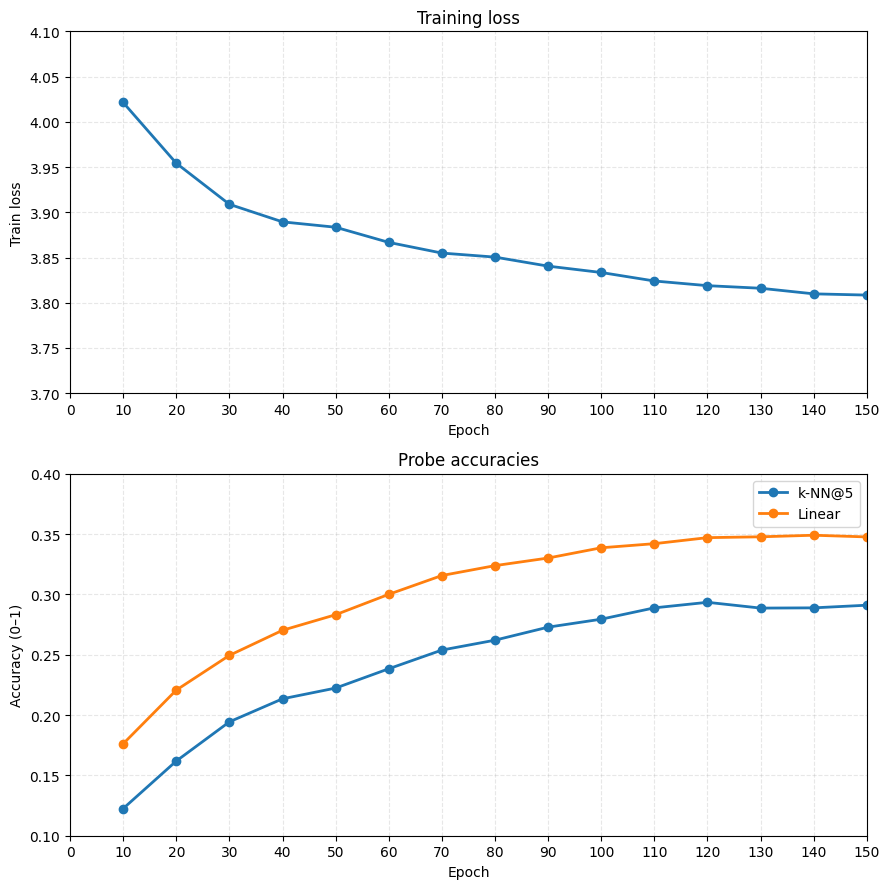

In [42]:
# ---- Plot with requested ranges ----
fig, axes = plt.subplots(2, 1, figsize=(9, 9))

# Training loss
ax = axes[0]
ax.plot(xs_loss, loss_pts, marker='o', lw=2)
ax.set_title("Training loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Train loss")
ax.set_xlim(0, total_epochs)
ax.set_ylim(3.7, 4.1)
ax.set_xticks(np.arange(0, total_epochs + 1, 10))
ax.grid(True, ls="--", alpha=0.3)

# Probe accuracies
ax = axes[1]
ax.plot(xs_probe, knn_pts,  marker='o', lw=2, label="k-NN@5")
ax.plot(xs_probe, linear_pts, marker='o', lw=2, label="Linear")
ax.set_title("Probe accuracies")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (0–1)")
ax.set_xlim(0, total_epochs)
ax.set_ylim(0.1, 0.4)
ax.set_xticks(np.arange(0, total_epochs + 1, 10))
ax.grid(True, ls="--", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [43]:
# we compute Val loss per checkpoint and plot Train vs Val
from safetensors.torch import load_model
from models import ImageEncoder

def avg_ntxent(model, loader, batches=None):
    model.eval()
    total, n = 0.0, 0
    with torch.no_grad():
        for i, (xb, _) in enumerate(loader):
            if batches is not None and i >= batches: break
            x1, x2 = make_two_views(xb)
            x1 = x1.to(device, non_blocking=True)
            x2 = x2.to(device, non_blocking=True)
            _, z1 = model(x1)
            _, z2 = model(x2)
            loss = custom_loss_function(z1, z2, temperature=tau)
            total += float(loss.item()); n += 1
    return total / max(1, n)

# VAL losses per checkpoint (full val loader)
probe_model = ImageEncoder().to(device)
val_x, val_y = [], []
for e in ckpt_epochs:
    load_model(probe_model, str(checkpoints_dir / f"model_epoch_{e}.safetensors"))
    val_x.append(e)
    val_y.append(avg_ntxent(probe_model, val_loader, batches=None))


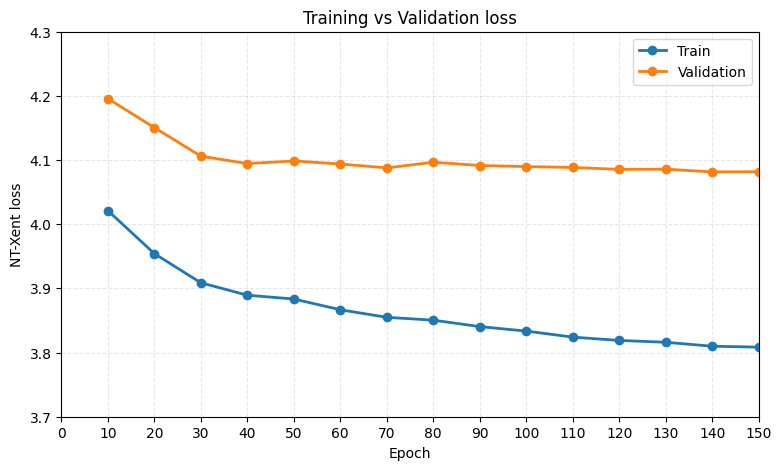

In [44]:
# Plot Train (already in xs_loss/loss_pts) vs Val
plt.figure(figsize=(9,5))
plt.plot(xs_loss, loss_pts, marker='o', lw=2, label="Train")
plt.plot(val_x,   val_y,   marker='o', lw=2, label="Validation")
plt.title("Training vs Validation loss")
plt.xlabel("Epoch"); plt.ylabel("NT-Xent loss")
plt.xlim(0, total_epochs); plt.ylim(3.7, 4.3)
plt.xticks(np.arange(0, total_epochs+1, 10))
plt.grid(True, ls="--", alpha=0.3); plt.legend()
plt.show()

# 7. Submission Instructions

You must submit the following files:
- `models.py`: Contains the implementation of your model architecture.
- `final_model.safetensors`: The trained model weights saved in the safetensors format.
- `report.md`: A brief report summarizing your approach, design choices, and results.
- `CS461_Assignment1.ipynb`: The Jupyter notebook containing your code and explanations. Make sure to save your progress before running the cell below.

You will submit your assignment under a single folder named `/home/cs461_assignment1_submission` containing the above files. \
Make sure to replace `<SCIPER>`, `<LAST_NAME>`, and `<FIRST_NAME>` with your actual SCIPER number, last name, and first name respectively. \
The following cell will help you move the files into the submission folder.

In [ ]:
work_dir = Path('.')
output_dir = Path.home() / 'cs461_assignment1_submission'

if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=False)

shutil.copy(final_model_path, output_dir / 'final_model.safetensors')
shutil.copy(work_dir / 'models.py', output_dir / 'models.py')
shutil.copy(work_dir / 'CS461_Assignment1.ipynb', output_dir / 'CS461_Assignment1.ipynb')
shutil.copy(work_dir / 'report.md', output_dir / 'report.md')

Check that all required files are present in the submission folder before running the cell below.

In [ ]:
assert SCIPER is not None and LAST_NAME is not None and FIRST_NAME is not None, "Please set your SCIPER, LAST_NAME, and FIRST_NAME variables."

list_of_files = ['final_model.safetensors', 'models.py', 'CS461_Assignment1.ipynb', 'report.md']
files_found = all((output_dir / f).exists() for f in list_of_files)
assert files_found, f"One or more required files are missing in the submission folder: {list_of_files}"


You can test whether your submission folder is appropriately structured by using the `eval.py`:
```bash
python eval.py
```

In [28]:
### Uncomment the line below to run the evaluation script and check your model's performance
!python eval.py

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Traceback (most recent call last):
  File "/content/drive/MyDrive/Assignment_1/cs461_assignment1/eval.py", line 68, in <module>
    assert work_dir.exists() and work_dir.is_dir(), \
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Submission folder /root/cs461_assignment1_submission does not exist or is not a directory.


---
🎉 **Congratulations!**  
You’ve completed Assignment 1. Good luck, and don’t forget to double-check your submission!